In [1]:
#imported required libraries

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob

# 1. Convert to csv

In [2]:
#specify the directory where the excel files are stored
#directory_path = r'C:/Users/PC/Downloads/web_files/Cape_Town_Fresh_Produce_Market_(CAP)/'

def combine_create_csv(directory_path):
    # Create the directory if it doesn't exist
    if not os.path.exists('market_csvs'):
        os.makedirs('market_csvs')
        
    # Create an empty list to store the dataframes of each Excel file
    excels = []

    # Loop through all the Excel files in the specified directory
    for file_name in os.listdir(directory_path):
        if file_name.endswith(".xls"):
            path = directory_path + file_name
            excel_file = pd.read_excel(path)
            excels.append(excel_file)
            # Extract market name from the first file and use it to name the CSV file
            if not os.path.exists('market_Csvs/combined_csv.csv'):
                market_name = directory_path.split('/')[-2]
                csv_name = f'{market_name}_combined.csv'
    # Concatenate all the dataframes
    combined_df = pd.concat(excels)
    # Export to CSV
    combined_df.to_csv(os.path.join('market_csvs', csv_name), index=False)
    return csv_name

#view result
#combine_create_csv(directory_path)

# 2. Clean the Data

I will create two functions.

1. the first function will carry out the processing of csv file
2. the second function will combine the first function to automatically carry out this processing in each dataframe and saved to a new folder

In [3]:
# Define a function to remove numbers from the beginning of the string
def remove_numbers(text):
        return ' '.join(text.split()[1:])

def clean_csv(csv_file):
    # specify the directory where the CSV file is stored
    directory_path = 'market_csvs/'
    df = pd.read_csv(directory_path + csv_file)
    # set the column names to the values in the first row
    df.columns = df.iloc[0]
    #drop first row
    df = df.drop(0)
    
    # Check if the dataframe has at least three rows
    if len(df.index) < 3:
        print(f"File {csv_file} has less than three rows of data and will be skipped")
        return None
    
    # extract the date information from the 'Unit' column
    dates = df['Unit'].str.split(', ', expand=True)[1]
    #dates = df['Unit'].str.split(', ', expand=True).apply(lambda x: x[1] if len(x) > 1 else '', axis=1)
    # add the date information as a new column in the dataframe
    df['Date'] = pd.to_datetime(dates, format='%d %B %Y')
    # Forward fill the NaT values in the Date column with the previous valid date
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce').ffill()
    # Convert the dates to the desired format
    df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
    #rename 'Unit' column and remove 'kg' from rows
    df.rename({'Unit':'Unit(kg)'},axis=1,inplace=True)
    df['Unit(kg)'] =df['Unit(kg)'].str.replace('kg','')
    df['Average Price'].replace({'ý':'0'},inplace=True)
    df.rename({"Total Sales":'Total Sales(Rand)'},axis=1,inplace=True)
    df['Total Sales(Rand)'] = df['Total Sales(Rand)'].astype(str)
    #remove R
    df['Total Sales(Rand)'] = df['Total Sales(Rand)'].str.replace('R','')
    #create new column for market name
    market = csv_file.split('_')[0]
    df['Market'] = f'{market}_market'
    ##rearange column index
    #create a list of desired column order
    new_order = ['Market','Date','Product', 'Variety', 'Class', 'Size', 'Package', 'Unit(kg)',
       'Closing Price', 'High Price', 'Low Price', 'Average Price',
       'Total Sales(Rand)', 'Sales Quantity', 'Closing Stock']
    # reorder the columns
    df= df.reindex(columns=new_order)
    
    df['Product'] = df['Product'].astype(str)
   
    # Apply the function to the 'fruits' column
    df['Product'] = df['Product'].apply(remove_numbers)
    #drop null rows
    df.dropna(inplace=True)
    #change date to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    df = df[(df["Variety"] != "Variety") & (df["Class"] != "Class") & 
       (df["Size"] != "Size") & (df["Package"] != "Package")
       & (df["Unit(kg)"] != "Unit") & (df["Closing Price"] != "Closing Price")
       & (df["High Price"] != "High Price") & (df["Low Price"] != "Low Price") & 
       (df["Total Sales(Rand)"] != "(Total Sales)") & (df["Sales Quantity"] != "Sales Quantity")
       & (df["Closing Stock"] != "Closing Stock")]
    #reset index
    df = df.reset_index(drop=True)
    #change datatype to numeric
    #df.iloc[:,6:] = df.iloc[:,6:].apply(pd.to_numeric, errors='coerce')
    df[df.columns[6:]] = df[df.columns[6:]].apply(pd.to_numeric, errors='coerce')
    df['Average Price'] = df[['High Price','Low Price']].mean(axis=1)
        
    #extract the day, week and month from the date column
    df['Day'] = pd.to_datetime(df['Date']).dt.dayofweek
    df['Month'] = pd.to_datetime(df['Date']).dt.month
    df['Week'] = pd.to_datetime(df['Date']).dt.isocalendar().week
    
    #drop package column
    df.drop('Package',axis=1,inplace=True)
    
    return df

In [4]:
def process_csv_files():
    for csv_file in os.listdir('market_csvs'):
        try:
            # Process the CSV file
            df = clean_csv(csv_file)
            if df is None:
                print(f"File {csv_file} has less than three rows of data and will be skipped")
                continue
            # Save the processed CSV file in the processed_csvs directory
            file_name = os.path.splitext(csv_file)[0] # remove the extension from the file name
            processed_file_path = f'processed_csvs/{file_name}.csv'
            df.to_csv(processed_file_path, index=False)
        except ValueError as e:
            print(f"Error processing file {csv_file}: {e}")
            
process_csv_files()

File Mpumalanga_Fresh_Produce_Market_(NEA)_combined.csv has less than three rows of data and will be skipped
File Mpumalanga_Fresh_Produce_Market_(NEA)_combined.csv has less than three rows of data and will be skipped


In [5]:
# Create the output directory if it doesn't exist
output_dir = 'combined_all'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Get a list of all CSV files in the input directory
input_dir = 'processed_csvs'
csv_files = glob.glob(os.path.join(input_dir, '*.csv'))

# Combine all CSV files into one dataframe
df_list = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    df_list.append(df)
combined_df = pd.concat(df_list, ignore_index=True)

# Write the combined dataframe to a CSV file
output_file = os.path.join(output_dir, 'horticulture_processed.csv')
combined_df.to_csv(output_file, index=False)


## Feature Engineering

In the machine learning workflow, once we've selected the model we want to use, selecting the appropriate features for that model is the next important step. In this lesson, we'll explore how to use correlation between features and the target column, correlation between features, and variance of features to select features.

In [6]:
df = pd.read_csv('combined_all/horticulture_processed.csv')

In [7]:
df.describe()

Unit(kg)  Closing Price    High Price     Low Price  Average Price  \
count  85792.000000   86122.000000  86122.000000  86122.000000   86122.000000   
mean       8.930512      73.566453     63.836137     46.670387      55.253262   
std       15.754559     154.772584    154.375552    124.190407     136.310896   
min        0.000000   -4950.000000      0.000000      0.000000       0.000000   
25%        4.000000       0.000000      0.000000      0.000000       0.000000   
50%        7.000000      42.400000      0.000000      0.000000       0.000000   
75%       10.000000     100.000000     90.000000     60.000000      80.000000   
max      420.000000    6729.000000   6729.000000   6729.000000    6729.000000   

       Total Sales(Rand)  Sales Quantity  Closing Stock           Day  \
count       8.612200e+04    86122.000000   86122.000000  86122.000000   
mean        1.204092e+04      162.472899     648.077797      1.915945   
std         4.673843e+04      574.222199    2922.960247      1.411857   
min        -8.200000e+04     -410.000000       0.000000      0.000000   
25%         0.000000e+00        0.000000      10.000000      1.000000   
50%         7.000000e+02       10.000000      75.000000      2.000000   
75%         6.100000e+03       86.000000     303.000000      3.000000   
max         1.648402e+06    23447.000000   33187.000000      4.000000   

              Month          Week  
count  86122.000000  86122.000000  
mean       2.250203      8.159971  
std        0.862289      3.391390  
min        1.000000      3.000000  
25%        2.000000      5.000000  
50%        2.000000      8.000000  
75%        3.000000     11.000000  
max        4.000000     16.000000

In [8]:
def correct_outliers(df):
    negatives = df[df['Closing Price'] < 0].index.tolist()
    df.loc[negatives,'Closing Price'] = df.loc[negatives,'Average Price']
    df[['Total Sales(Rand)','Sales Quantity']] = abs(df[['Total Sales(Rand)','Sales Quantity']])
    return df

df = correct_outliers(df)

# Visualization

## 1. Which market recorded the most sales?

In [9]:
import plotly.express as px

market_sales = df.groupby('Market')['Total Sales(Rand)'].sum().reset_index()

fig = px.bar(market_sales,x='Market',y='Total Sales(Rand)')
fig.show()

## 2. Price trends: 

We can analyze the high and low prices of each product over time to determine any trends in price fluctuations. This can be useful for both buyers and sellers in predicting future prices and making informed decisions.

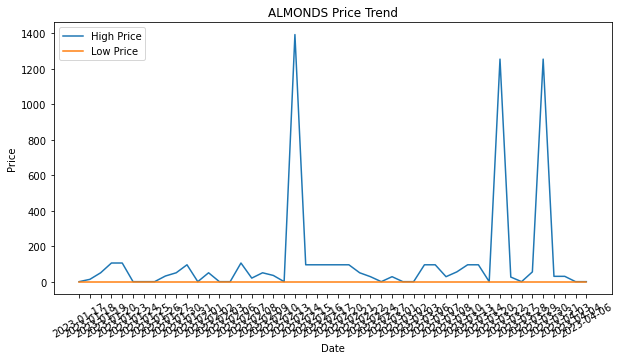

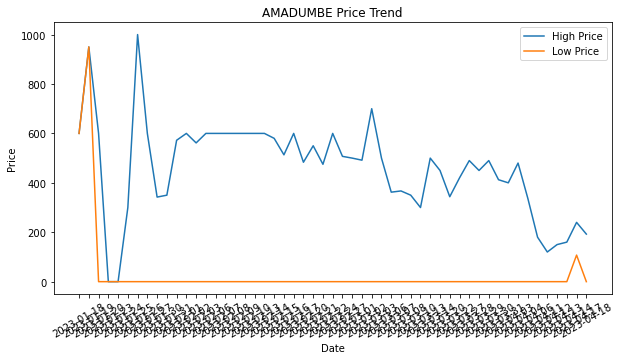

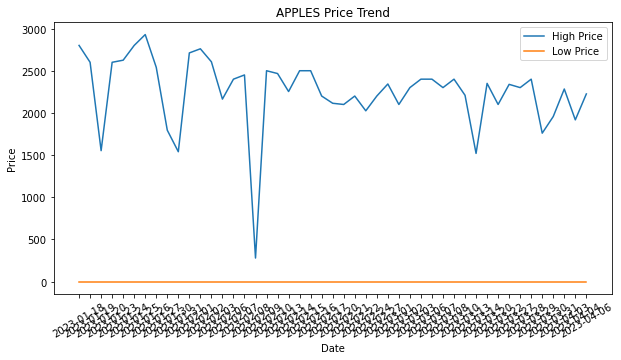

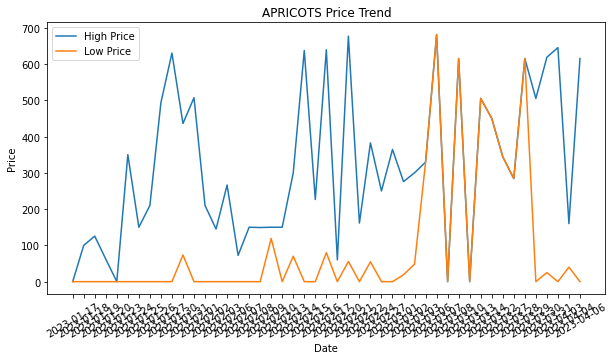

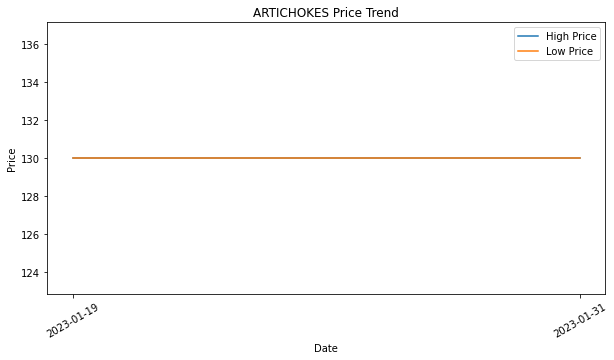

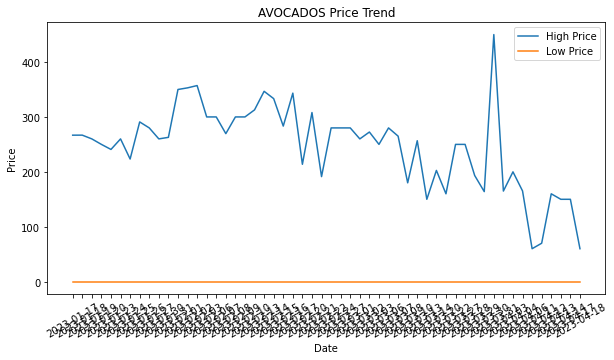

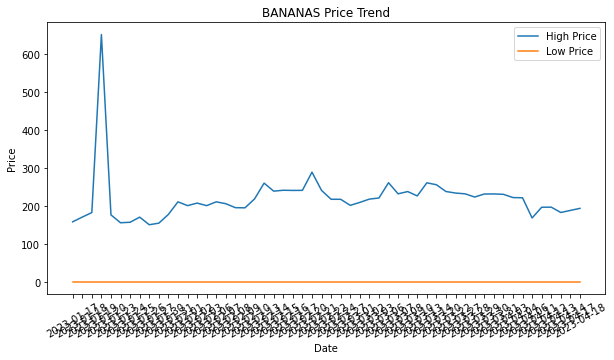

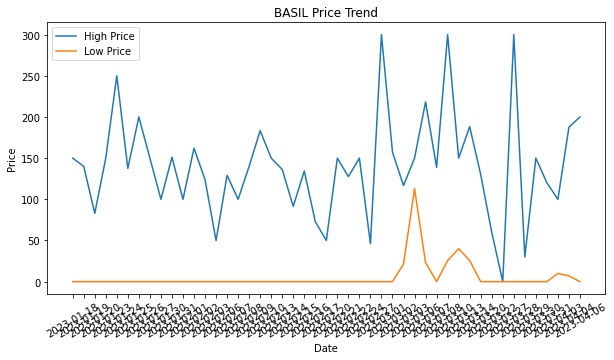

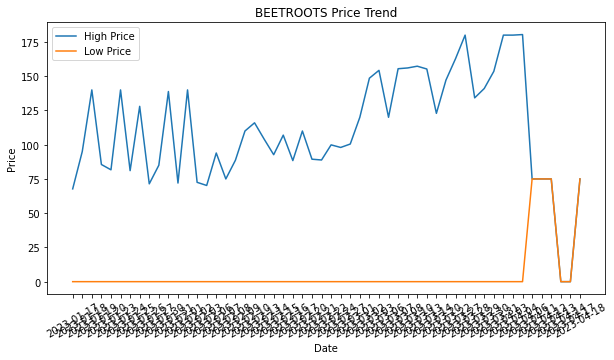

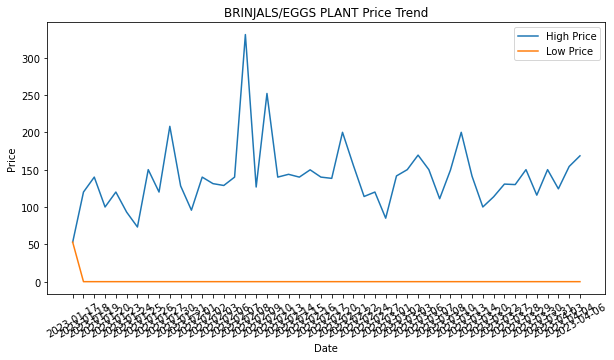

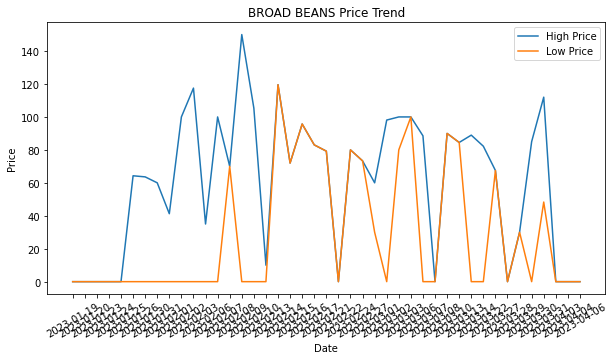

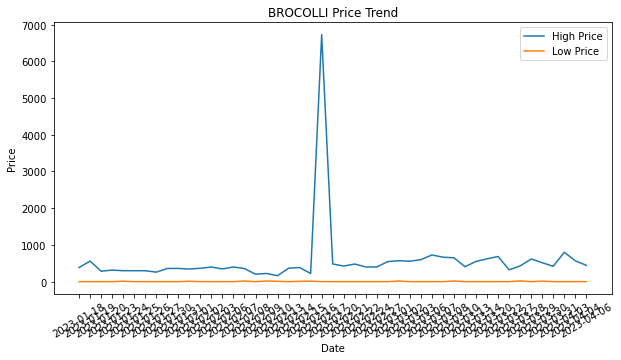

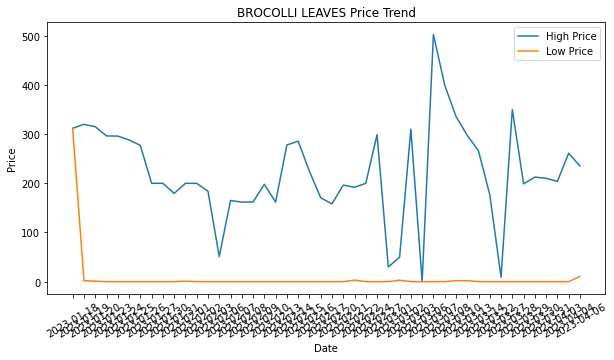

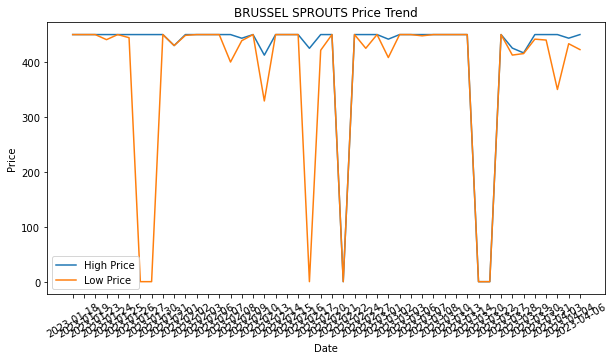

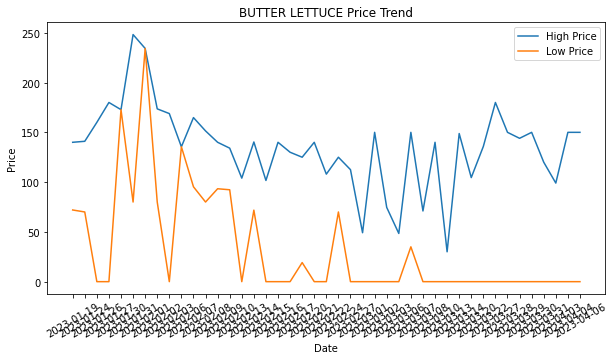

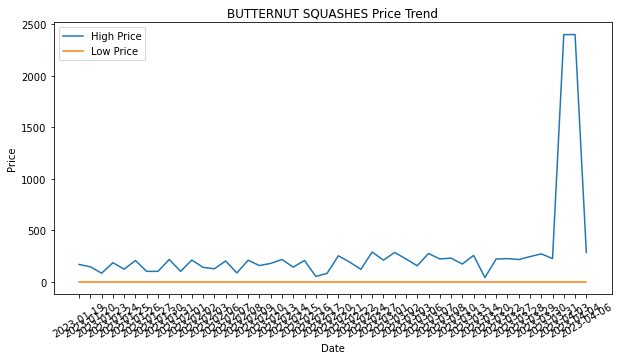

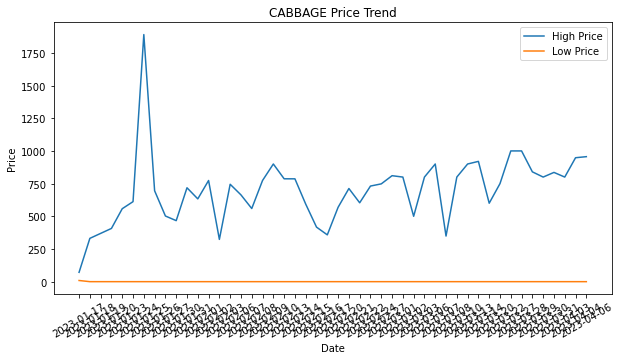

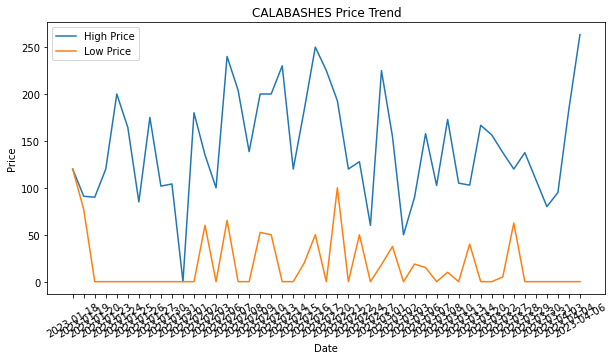

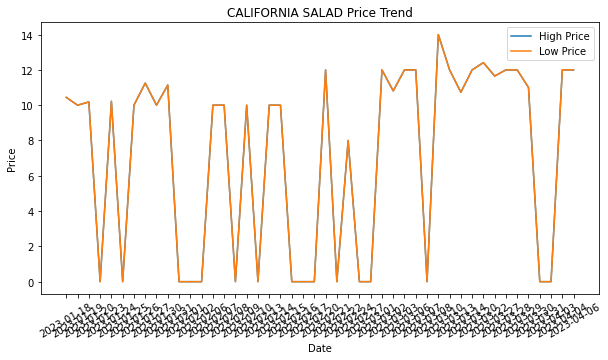

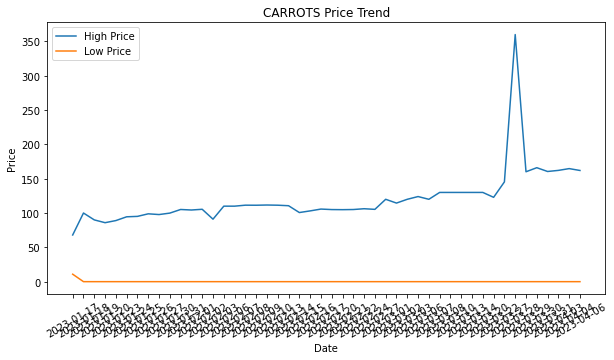

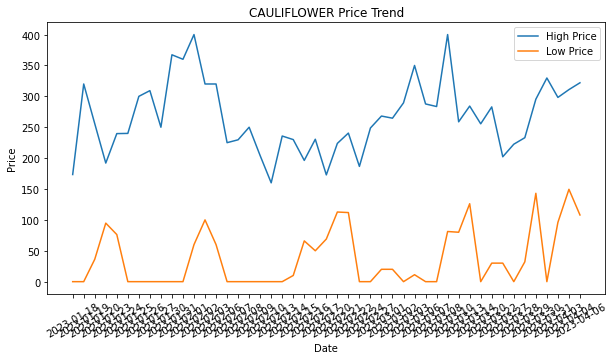

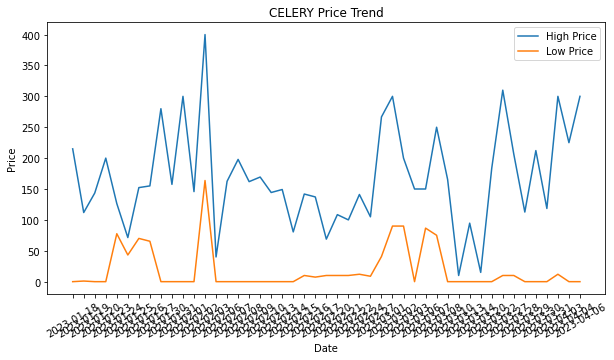

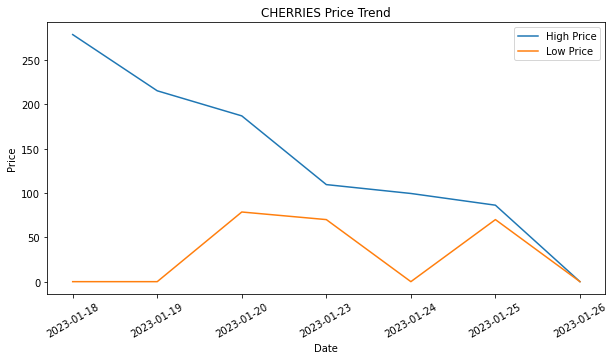

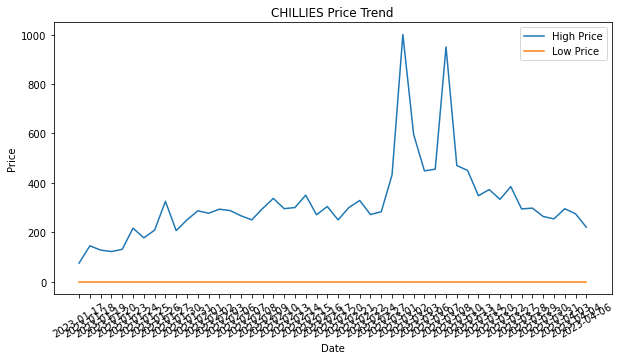

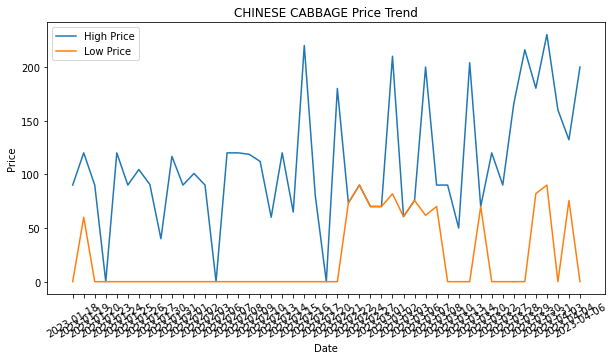

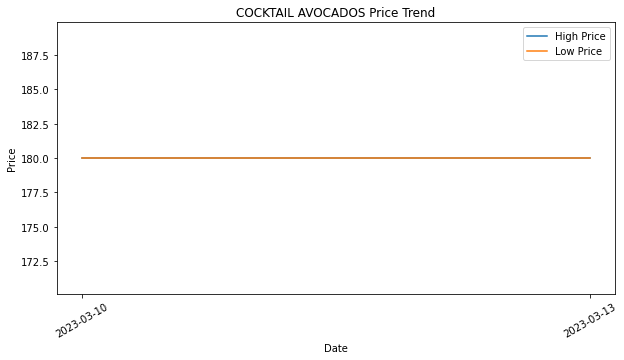

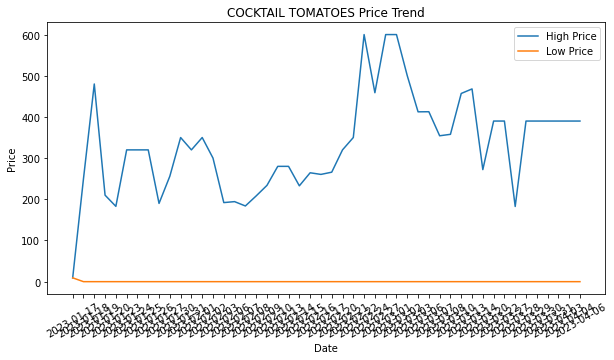

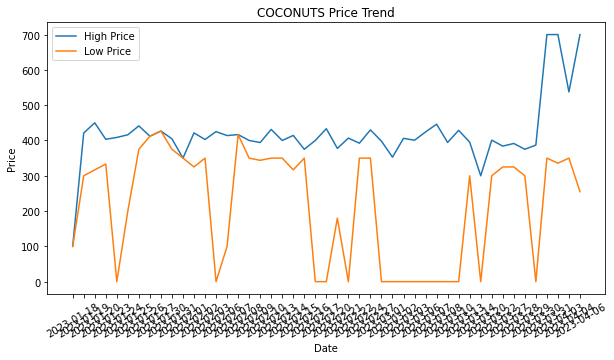

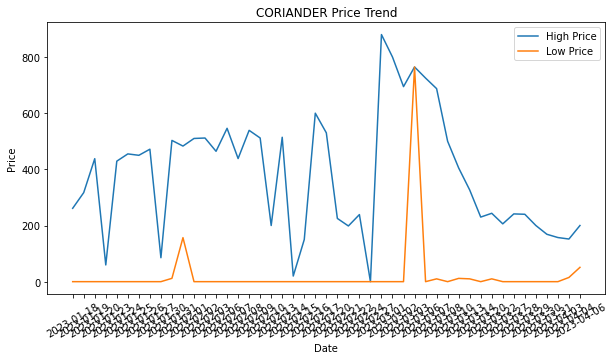

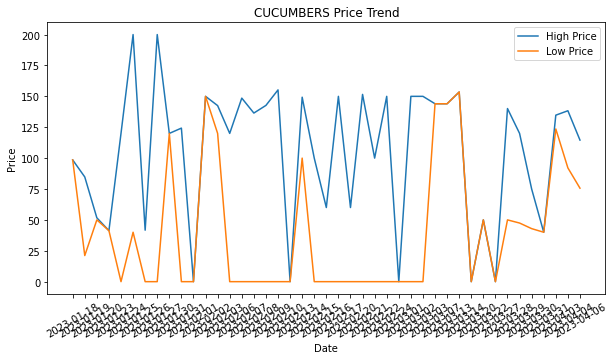

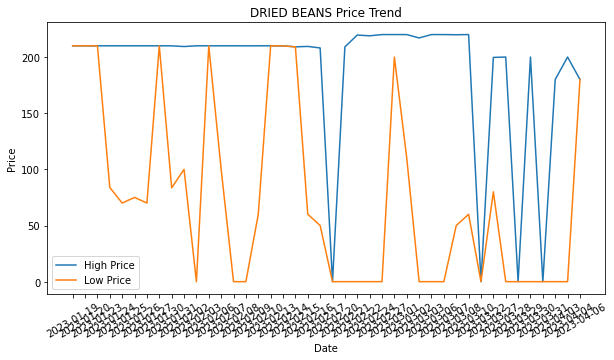

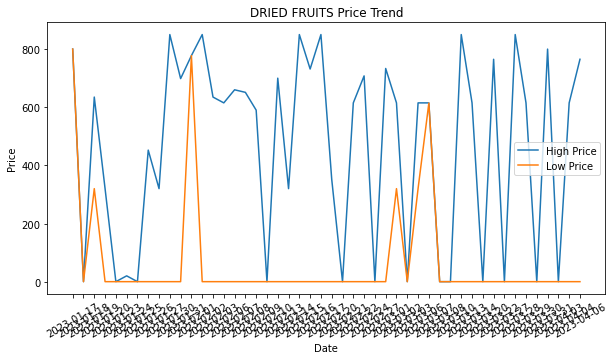

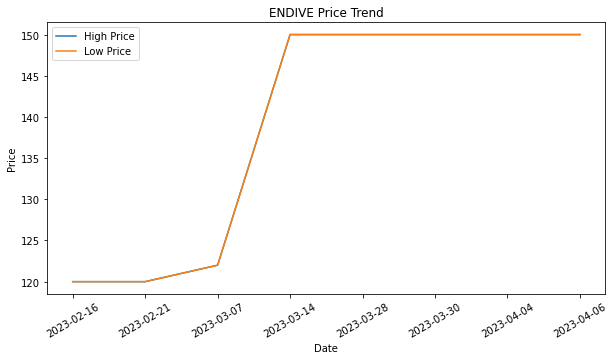

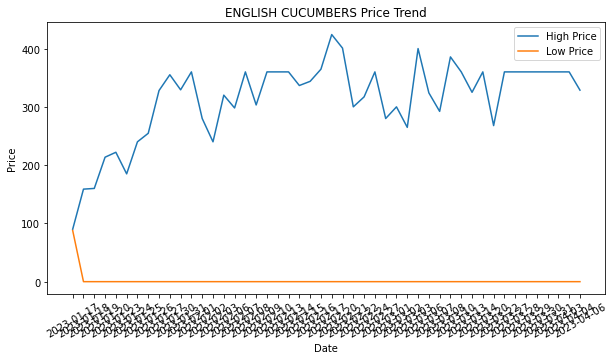

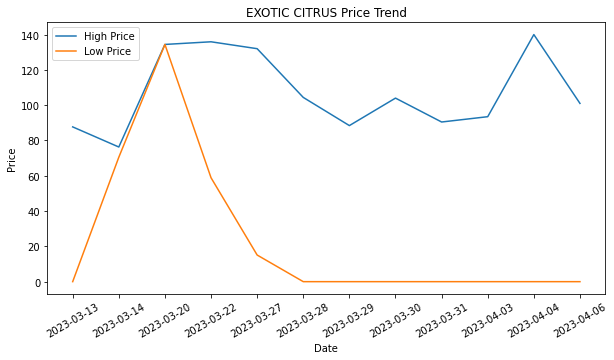

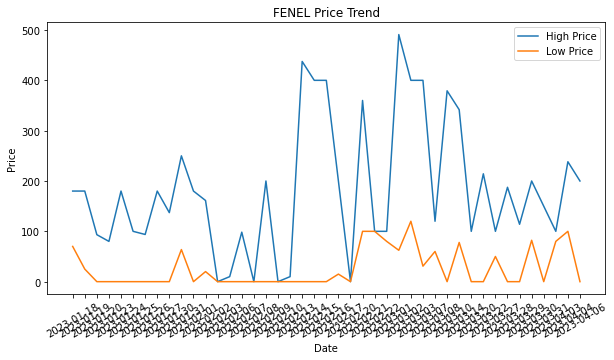

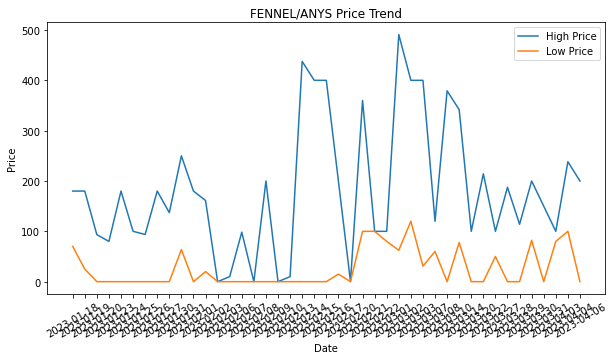

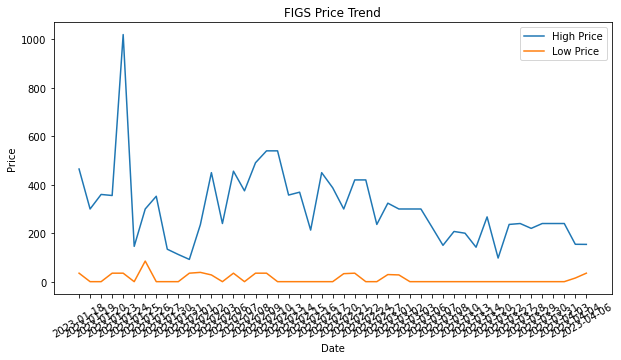

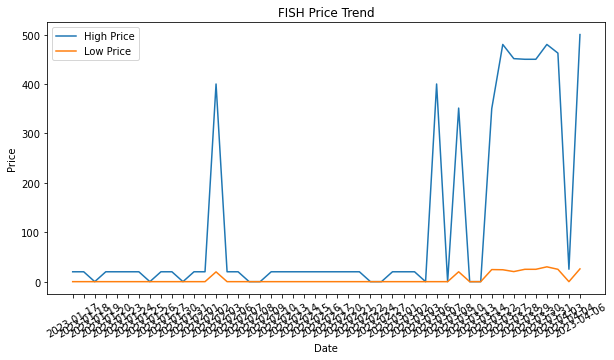

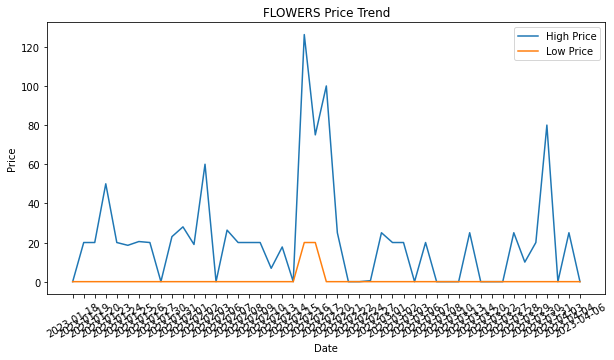

KeyboardInterrupt: 

In [10]:
# Group the data by product and date, and calculate the mean, minimum, and maximum prices for each group
grouped_data = df.groupby(["Product", "Date"]).agg({"Closing Price": ["mean", "min", "max"]})

# Flatten the multi-level column names
grouped_data.columns = ["_".join(col) for col in grouped_data.columns.values]

# Loop through each unique product and create a separate plot for each
for product in grouped_data.index.get_level_values(0).unique():
    plt.figure(figsize=[10,5])
    product_data = grouped_data.loc[product]
    plt.plot(product_data.index, product_data["Closing Price_max"], label="High Price")
    plt.plot(product_data.index, product_data["Closing Price_min"], label="Low Price")
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title(f"{product} Price Trend")
    plt.xticks(rotation=30)

    # Show the plot for the current product
    plt.show()


## 3: Seasonal Trends:

Certain produce has a seasonal supply and demand cycle. By analyzing the sales quantity and price trends, you can identify the peak seasons for each product, and adjust your supply and demand accordingly.

In [11]:
#map month names

month_names = {
    1: 'January',
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'August',
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December'
}

df['Month'] = df['Month'].map(month_names)

In [12]:
#calculate the average price and sales quality of each month
monthly_data = df.groupby('Month').agg({'Average Price': 'mean', 'Sales Quantity': 'sum'}).reset_index()

fig = px.bar(monthly_data, x='Month', y=['Average Price', 'Sales Quantity'], barmode='group')
fig.show()

## 4. Product popularity: 

By analyzing the sales quantity and total sales, you can determine which products are most popular in a particular market, and adjust your production or marketing strategy accordingly.

In [13]:
popular_df = df.groupby('Product').agg({'Total Sales(Rand)': 'sum', 'Sales Quantity': 'sum'}).reset_index()
fig = px.bar(popular_df, x='Product', y=['Total Sales(Rand)', 'Sales Quantity'], barmode='group')
fig.show()

It looks like Bananas and carrots tomatoes are some of the most popular products in this market

## 4. Class and size preferences: 

The dataset also includes information about the class and size of the produce sold. You can use this information to determine which classes and sizes are most in demand in a particular market, and adjust your product offering accordingly.

In [14]:
class_group = df.groupby('Class')['Total Sales(Rand)'].sum().reset_index()
fig = px.bar(class_group, x = 'Class', y = 'Total Sales(Rand)')
fig.show()

In [15]:
size_group = df.groupby('Size')['Total Sales(Rand)'].sum().reset_index()
fig = px.bar(size_group, x = 'Size', y = 'Total Sales(Rand)')
fig.show()

## 5. Which day was the most sales recorded?

In [16]:
#import plotly.graph_objects as go
date_group = df.groupby('Date')['Total Sales(Rand)'].sum().reset_index()

fig = px.line(date_group,x = 'Date', y ='Total Sales(Rand)')
fig.show()

In [17]:
day_names = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

df['Day'] = df['Day'].map(day_names)

In [18]:
day_group = df.groupby('Day')['Total Sales(Rand)'].sum().reset_index()
fig = px.pie(day_group, values='Total Sales(Rand)', names="Day")
fig.show()